# CNN   Vgg16  transferencia de aprendizaje

### Librerias comunes a todas las redes usadas

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import random as python_random
from PIL import Image
from pathlib import Path
import seaborn as sns
import itertools

### Librerias particulares en Keras

In [2]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [3]:
import tensorflow as tf

### Fijar las semillas pseudoaleatorias para reproductibilidad de los modelos

In [4]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

### Variables generales

In [5]:
tamaño_imagen=100
IMG_SIZE = (tamaño_imagen, tamaño_imagen) #28
shape=[tamaño_imagen,tamaño_imagen]
epocas=10
modelo_nombre='vgg16_tfm'
umbral=0.5  # 0.5   Variar umbral cambia criterio Positivo o negativo
input_folder = 'dataset'  
output_folder= 'dividido'
modelos_folder='modelos/'
train_dir = output_folder+"/train/"
val_dir = output_folder+"/val/"
test_dir = output_folder+"/test/"
ratio_entreno=0.8
ratio_val=0.1
ratio_test=0.1
colores='rgb' #  alternativa   colores='rgb'
batch_size = 32

In [6]:
def cargar_ejemplos():
    P_image = Image.open(input_folder+'/P/0p.jpg')
    N_image = Image.open(input_folder+'/N/0n.jpg')
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.xlabel('P  (MonkeyPox)')
    plt.imshow(P_image)
    plt.subplot(1,2,2)
    plt.xlabel('N  (Sano)')
    plt.imshow(N_image)

In [7]:
def divide_dataset(origen,destino,entrena_ratio,val_ratio,test_ratio):
    if entrena_ratio+val_ratio+test_ratio==1:
         if not(Path(destino).is_dir()):
            splitfolders.ratio(origen, output= destino, seed=1337, ratio = (entrena_ratio,val_ratio,test_ratio))
    else:  
        print ("Error en los ratios, deben sumar 1")

In [8]:
def cambia_extension(path1):
    contador=0
    for dirs in os.listdir(path1):
        path2=path1+'/'+dirs
        for subdir in os.listdir(path2):
            path3=path2+'/'+subdir
            for files in os.listdir(path3):
                filename, extension = os.path.splitext(files)
                if extension==".jfif":
                    contador+=1
                    os.rename(path3+'/'+files, path3+'/'+filename+str(contador)+'.jpg')
    print("Se han cambiado las extensiones de: ", contador)

In [9]:
def generar_trenes_datos(train_dir,val_dir,test_dir,colores,IMG_SIZE):

    gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_data = gen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        shuffle=True,
        batch_size=batch_size,
    )
    val_data = gen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        shuffle=True,
        batch_size=batch_size,
    )
    
    test_data = gen.flow_from_directory(
        test_dir, 
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=1,)
    
    return gen,train_data, val_data, test_data

In [10]:
def crea_etiquetas(tren):
    print(tren.class_indices)
    labels = [None] * len(test_data.class_indices)
    for k, v in test_data.class_indices.items():
        labels[v] = k

    for x, y in test_data:
        print("min:", x[0].min(), "max:", x[0].max())
        plt.title(labels[np.argmax(y[0])])
        plt.imshow(x[0])
        plt.show()
        break
    return labels

In [11]:
def guarda_modelo(modelo):
    modelo.save(modelos_folder+modelo_nombre+'.h5')
    print("Modelo guardado como: ",modelo_nombre+'.h5')

In [12]:
def guarda_history(modelo):
    df=pd.DataFrame(modelo.history)
    df.plot(figsize=(8,5))
    plt.show()
    df.to_csv(modelos_folder+modelo_nombre+'.csv', sep=';')
    print("History guardado como: ",modelo_nombre+'.csv')

In [13]:
def datos_trenes_analisis():
    image_files = glob(train_dir + '/*/*.*')
    valid_image_files = glob(val_dir + '/*/*.*')
    test_image_files = glob(test_dir + '/*/*.*')
    print("Number of Images for Training: ",len(image_files))
    print("Number of Images for validating: ",len(valid_image_files))
    print("Number of Images for testing: ",len(test_image_files))
    folders = glob(train_dir + '/*')
    print("Number of classes: ",len(folders))
    plt.imshow(image.load_img(np.random.choice(image_files)))
    plt.show()
    return image_files,valid_image_files,test_image_files

In [14]:
def evalua_modelo(modelo):
    #Evaluacion del modelo
    scores=modelo.evaluate(train_data,verbose=True)
    print("Precisión de entrenamiento: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(val_data,verbose=True)
    print("Precisión de validacion: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(test_data,verbose=True)
    print("Precisión de prueba: %.1f%%\n"%(scores[1]*100))

In [15]:
def evalua2(modelo,data_path, N,labels):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMG_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = modelo.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    acsc=accuracy_score(targets, predictions)
    print('La precisión sobre el conjunto de test, es:',acsc)
    print('Las metricas principales son:')
    print(classification_report(targets, predictions, target_names=labels))
    cm = confusion_matrix(targets, predictions)

    sns.heatmap(cm.astype("int"), annot=True,cmap='Blues')
    #Curva Roc
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curva')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return cm, acsc,predictions,targets

In [16]:
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Etiqueta')
    plt.xlabel('Predicha Etiqueta')
    plt.show()

In [17]:
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Etiqueta')
    plt.xlabel('Predicha Etiqueta')
    plt.show()

In [18]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  recall = history.history['recall']
  val_recall = history.history['val_recall']
    
  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

  # Plot recall
  plt.figure()
  plt.plot(epochs, accuracy, label='training_recall')
  plt.plot(epochs, val_accuracy, label='val_recall')
  plt.title('Recall')
  plt.xlabel('Epochs')
  plt.legend();

In [19]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred
def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [20]:
LOSS_METRICS = ['accuracy',recall]

# A - Tratamiento previo del dataset

### 1. Cargar imágenes 

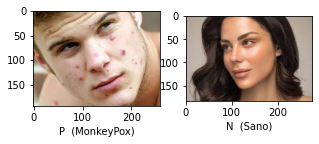

In [21]:
cargar_ejemplos()

###  2.- Dividir el dataset en entrenamiento + Validación + test <p>
Esta función lo hace, pero antes comprueba que no esté ya hecho, para no repetir el proceso.

In [22]:
divide_dataset(input_folder,output_folder,ratio_entreno, ratio_val, ratio_test)

### 3.- Corregir extensiones no compatible

El dataset original contiene ficheros con extensiones tipo '.jfif', que No son reconocidas por train_generator como imágenes<p>
Esta pequeña función renombra esas extensiones a jpg que sí son compatibles, de este modo operará con el dataset completo en número de imágenes disponibles

In [23]:
cambia_extension(output_folder)

Se han cambiado las extensiones de:  0


 ###  Antes  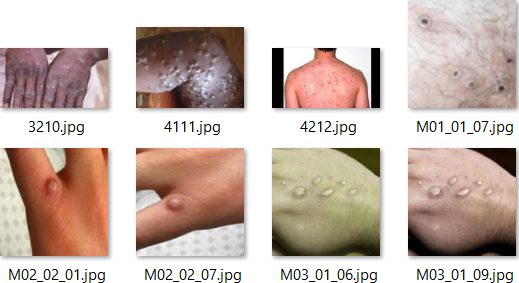

# Despues 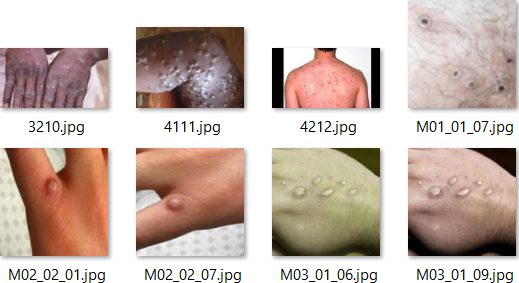

### 4.- Carga de Datos

In [24]:
gen,train_data, val_data, test_data=generar_trenes_datos(train_dir,val_dir,test_dir,colores,IMG_SIZE)

Found 3104 images belonging to 2 classes.
Found 387 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


Number of Images for Training:  3106
Number of Images for validating:  387
Number of Images for testing:  390
Number of classes:  2


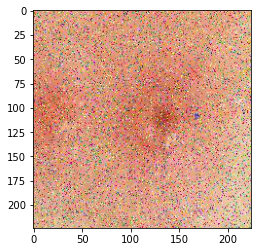

In [25]:
image_files,valid_image_files,test_image_files=datos_trenes_analisis()

# Arquitectura Vgg-16

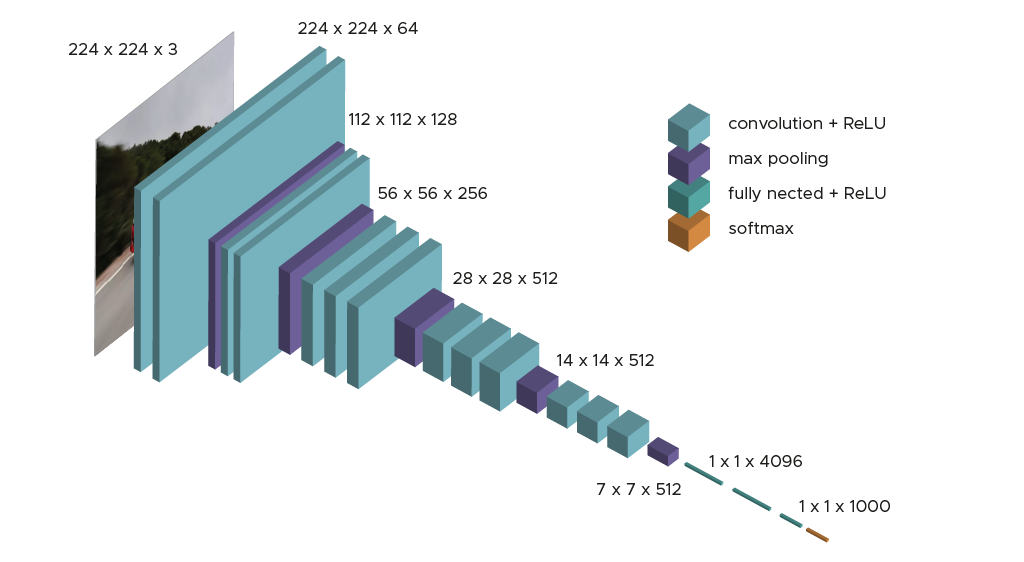

### 5.- Modelar la Red Neuronal

In [26]:
vgg = VGG16(input_shape=shape + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
vgg16_tfm = Model(inputs=vgg.input, outputs=prediction)
vgg16_tfm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

### Definir optimizador y funciones de perdidas y precision

In [27]:
vgg16_tfm.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=LOSS_METRICS   #['accuracy',recall]
)

### 6.- Entrenar la Red

In [28]:
histoy_vgg16 = vgg16_tfm.fit(
  train_data,
  validation_data=val_data,
  epochs=epocas,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/10
97/97 [==============================] - 70s 480ms/step - loss: 2.3615 - accuracy: 0.7819 - recall: 0.7239 - val_loss: 1.9938 - val_accuracy: 0.8255 - val_recall: 0.6014
Epoch 2/10
97/97 [==============================] - 46s 471ms/step - loss: 0.6178 - accuracy: 0.9075 - recall: 0.8809 - val_loss: 1.1183 - val_accuracy: 0.8802 - val_recall: 0.8962
Epoch 3/10
97/97 [==============================] - 46s 469ms/step - loss: 0.4044 - accuracy: 0.9385 - recall: 0.9261 - val_loss: 1.1266 - val_accuracy: 0.8958 - val_recall: 0.8947
Epoch 4/10
97/97 [==============================] - 46s 474ms/step - loss: 0.3079 - accuracy: 0.9549 - recall: 0.9469 - val_loss: 1.3277 - val_accuracy: 0.9089 - val_recall: 0.8296
Epoch 5/10
97/97 [==============================] - 46s 473ms/step - loss: 0.1665 - accuracy: 0.9694 - recall: 0.9612 - val_loss: 1.2330 - val_accuracy: 0.9141 - val_recall: 0.8812
Epoch 6/10
97/97 [==============================] - 45s 465ms/step - loss: 0.1787 - accuracy: 0

### 7.- Guardar el modelo ya entrenado

In [29]:
guarda_modelo(vgg16_tfm)

Modelo guardado como:  vgg16_tfm.h5


### 8.- Evaluar modelo

Generar metricas

In [30]:
evalua_modelo(vgg16_tfm)

97/97 [==============================] - 41s 419ms/step - loss: 0.0121 - accuracy: 0.9965 - recall: 0.9938
Precisión de entrenamiento: 99.6%

13/13 [==============================] - 9s 662ms/step - loss: 1.7436 - accuracy: 0.9096 - recall: 0.8444
Precisión de validacion: 91.0%

390/390 [==============================] - 34s 82ms/step - loss: 1.7169 - accuracy: 0.9051 - recall: 0.3308
Precisión de prueba: 90.5%



### El modelo sobreajusta a partir de la época 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'N': 0, 'P': 1}
min: -123.68 max: 131.32


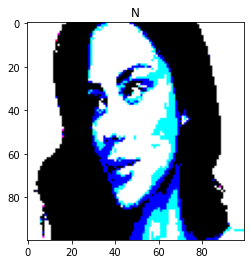

In [31]:
labels=crea_etiquetas(test_data)

Generating confusion matrix 390
Found 390 images belonging to 2 classes.
La precisión sobre el conjunto de test, es: 0.9051282051282051
Las metricas principales son:
              precision    recall  f1-score   support

           N       0.91      0.94      0.92       238
           P       0.90      0.85      0.87       152

    accuracy                           0.91       390
   macro avg       0.90      0.89      0.90       390
weighted avg       0.91      0.91      0.90       390



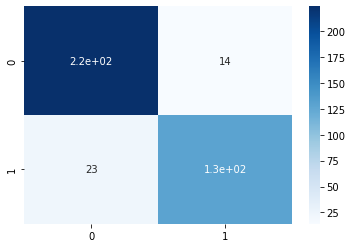

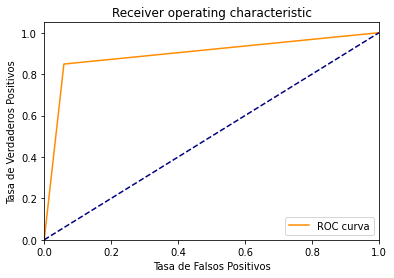

In [32]:
cm,ascs,predichos,reales=evalua2(vgg16_tfm,test_dir, len(test_image_files),labels)

### matriz confusión en colores azules

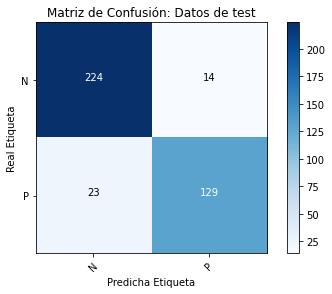

In [33]:
plot_confusion_matrix(cm, labels, title='Matriz de Confusión: Datos de test')

### 9.- Curvas métricas de entrenamiento

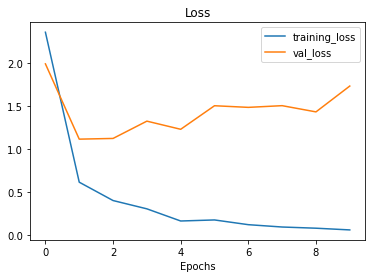

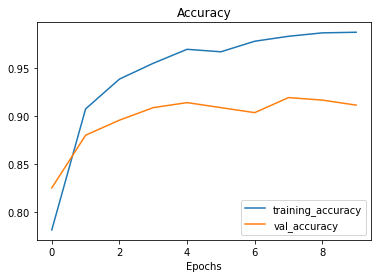

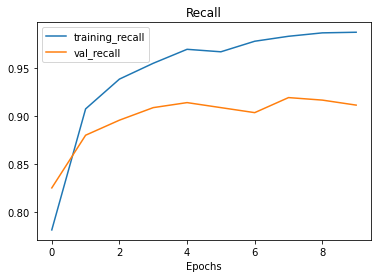

In [34]:
plot_loss_curves(histoy_vgg16)

### Guarda el historial

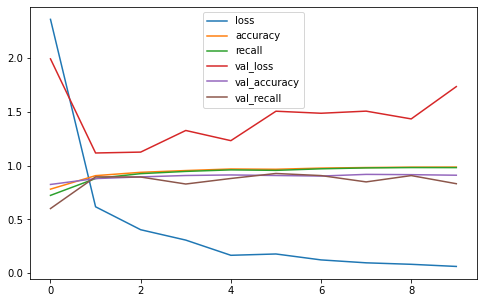

History guardado como:  vgg16_tfm.csv


In [35]:
guarda_history(histoy_vgg16)

###  10.- Comprobar visualmente las predicciones 

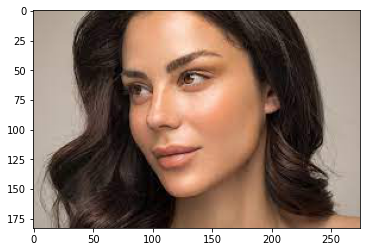

In [36]:
plt.imshow(image.load_img(test_image_files[0]))
plt.show()

In [37]:
resultados=["N" if x==0.0 else "P" for x in predichos]
print("Predicción de la imagen de prueba: ",predichos[0], resultados[0],"\n")

Predicción de la imagen de prueba:  0.0 N 

